In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from src.hmm import get_likelihood
from src.test_hmm import generate_data
import numpy as np
(
    initial_conditions,
    transition_matrix,
    emission_matrix,
    _,
    observations_ind,
) = generate_data()

likelihood = get_likelihood(emission_matrix, observations_ind)
log_likelihood = np.log(likelihood)

In [3]:
from src.hmm3 import forward, smoother, estimate_transition_matrix
from src.hmm import check_converged

tolerance = 1e-4
max_iter = 10

marginal_log_likelihoods = []
n_iter = 0
converged = False

while not converged and (n_iter < max_iter):
    # Expectation
    causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
        initial_conditions, log_likelihood, transition_matrix
    )
    acausal_posterior = smoother(
        causal_posterior, predictive_distribution, transition_matrix
    )

    # Maximization
    initial_conditions = acausal_posterior[0]
    transition_matrix = estimate_transition_matrix(
        causal_posterior,
        predictive_distribution,
        transition_matrix,
        acausal_posterior,
    )

    # Stats
    n_iter += 1

    marginal_log_likelihoods.append(marginal_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = marginal_log_likelihoods[-1] - marginal_log_likelihoods[-2]
        converged, increasing = check_converged(
            marginal_log_likelihoods[-1], marginal_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {marginal_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, " f"likelihood: {marginal_log_likelihoods[-1]}")

iteration 1, likelihood: -5.52629188048878
iteration 2, likelihood: -5.196275693126898, change: 0.3300161873618821
iteration 3, likelihood: -5.061668421513359, change: 0.1346072716135387
iteration 4, likelihood: -5.0051811078015715, change: 0.056487313711787834
iteration 5, likelihood: -4.979502269145067, change: 0.025678838656504333
iteration 6, likelihood: -4.966752071535579, change: 0.012750197609488367
iteration 7, likelihood: -4.95990981792989, change: 0.00684225360568913
iteration 8, likelihood: -4.956005190566726, change: 0.0039046273631635486
iteration 9, likelihood: -4.953671586066631, change: 0.002333604500095454
iteration 10, likelihood: -4.952228345129033, change: 0.001443240937597956


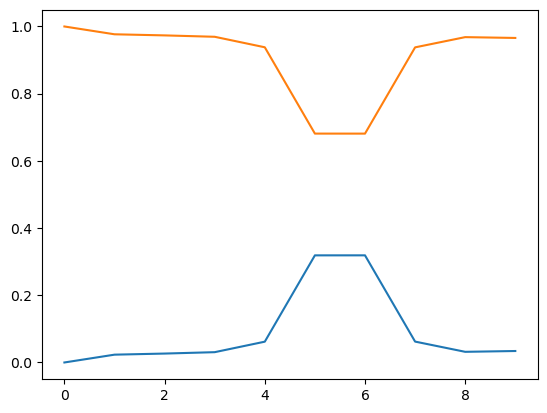

In [4]:
import matplotlib.pyplot as plt

# Expectation
causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
    initial_conditions, log_likelihood, transition_matrix
)
acausal_posterior = smoother(
    causal_posterior, predictive_distribution, transition_matrix
)
plt.plot(acausal_posterior)

iteration 1, likelihood: -2382.3368977434643
iteration 2, likelihood: -2379.6257713395594, change: 2.7111264039049274
iteration 3, likelihood: -2376.2524738690477, change: 3.373297470511716
iteration 4, likelihood: -2372.6900019702057, change: 3.5624718988419772
iteration 5, likelihood: -2369.4756830942824, change: 3.2143188759232544
iteration 6, likelihood: -2366.9219736975147, change: 2.553709396767772
iteration 7, likelihood: -2365.033286545876, change: 1.8886871516388055
iteration 8, likelihood: -2363.6275976407696, change: 1.4056889051062171
iteration 9, likelihood: -2362.492660321669, change: 1.1349373191005725
iteration 10, likelihood: -2361.467880031948, change: 1.0247802897210931
iteration 11, likelihood: -2360.455163214517, change: 1.012716817430828
iteration 12, likelihood: -2359.400383257499, change: 1.0547799570181269
iteration 13, likelihood: -2358.2731438277387, change: 1.127239429760266
iteration 14, likelihood: -2357.0533294359057, change: 1.219814391833097
iteration 1

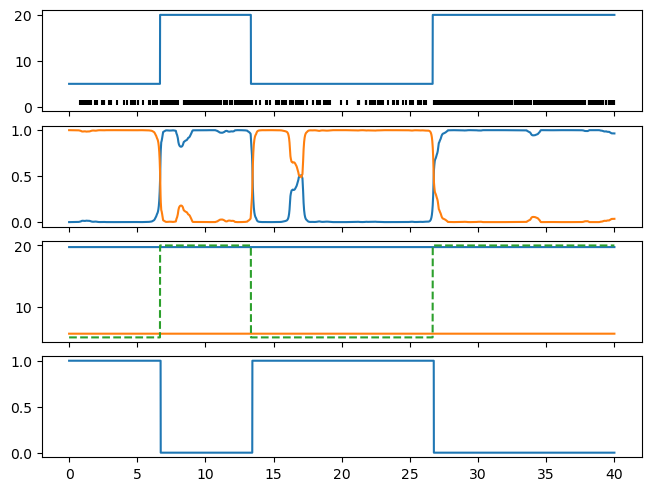

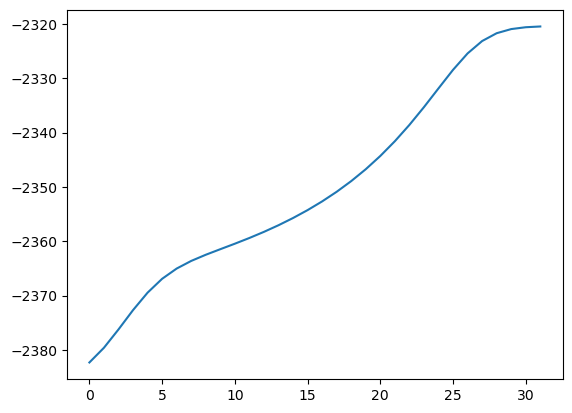

In [5]:
from src.test_hmm import simulate_two_state_poisson
from src.hmm import poisson_log_likelihood, check_converged, viterbi
from src.hmm3 import forward, smoother, estimate_transition_matrix
import numpy as np
import matplotlib.pyplot as plt

# from src.hmm import forward, correction_smoothing

sampling_frequency = 500
time, true_rate, spikes = simulate_two_state_poisson(
    sampling_frequency=sampling_frequency
)
spike_time_ind = np.nonzero(spikes)[0]


tolerance = 1e-4
max_iter = 50

marginal_log_likelihoods = []
ecll = []
ecll_iter = []
n_iter = 0
converged = False

n_states = 2
n_time = spikes.shape[0]
initial_conditions = np.ones((n_states,)) / n_states
transition_matrix = np.asarray([[0.98, 0.02],
                                [0.02, 0.98]])
is_training = np.ones((n_time,))
is_training[: n_time // 2] = 0.0


while not converged and (n_iter < max_iter):
    predict_rates = np.asarray(
        (
            np.average(spikes, weights=is_training.astype(float)),
            np.average(spikes, weights=1 - is_training.astype(float)),
        )
    )[np.newaxis]
    predict_rates = np.ones((n_time, 1)) * predict_rates
    log_likelihood = poisson_log_likelihood(spikes[:, np.newaxis], predict_rates)
    
    # Expectation
    causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
        initial_conditions, log_likelihood, transition_matrix
    )
    acausal_posterior = smoother(
        causal_posterior, predictive_distribution, transition_matrix
    )
    
    # causal_posterior, marginal_log_likelihood, scaling = forward(
    #     initial_conditions, np.exp(log_likelihood), transition_matrix
    # )
    # acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)

    # Maximization
    is_training = acausal_posterior[:, 0]
    initial_conditions = acausal_posterior[0]
    transition_matrix = estimate_transition_matrix(
        causal_posterior,
        predictive_distribution,
        transition_matrix,
        acausal_posterior,
    )
    
        # Stats
    n_iter += 1

    marginal_log_likelihoods.append(marginal_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = marginal_log_likelihoods[-1] - marginal_log_likelihoods[-2]
        converged, increasing = check_converged(
            marginal_log_likelihoods[-1], marginal_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {marginal_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, " f"likelihood: {marginal_log_likelihoods[-1]}")
        
        
predicted_state = viterbi(initial_conditions, np.exp(log_likelihood), transition_matrix)[0]

fig, axes = plt.subplots(4, 1, constrained_layout=True, sharex=True)
axes[0].plot(time, true_rate)
axes[0].eventplot(time[spike_time_ind], color="black")

axes[1].plot(time, acausal_posterior)
axes[2].plot(time, predict_rates * sampling_frequency)
axes[2].plot(time, true_rate, linestyle="--")
axes[3].plot(time, predicted_state)

plt.figure()
plt.plot(marginal_log_likelihoods)

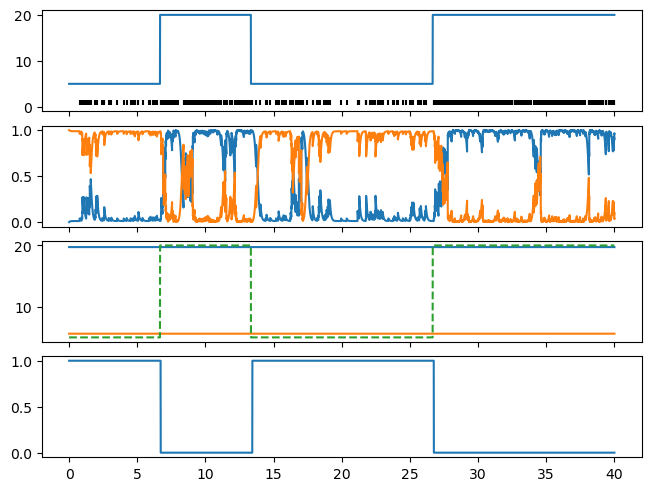

In [6]:
fig, axes = plt.subplots(4, 1, constrained_layout=True, sharex=True)
axes[0].plot(time, true_rate)
axes[0].eventplot(time[spike_time_ind], color="black")

axes[1].plot(time, causal_posterior)
axes[2].plot(time, predict_rates * sampling_frequency)
axes[2].plot(time, true_rate, linestyle="--")
axes[3].plot(time, predicted_state)

In [7]:
from src.test_hmm import simulate_two_state_poisson
from src.hmm import poisson_log_likelihood, check_converged, viterbi
from src.hmm3 import forward, smoother, estimate_transition_matrix
import numpy as np
import matplotlib.pyplot as plt

# from src.hmm import forward, correction_smoothing

sampling_frequency = 500
time, true_rate, spikes = simulate_two_state_poisson(
    sampling_frequency=sampling_frequency
)
spike_time_ind = np.nonzero(spikes)[0]


tolerance = 1e-4
max_iter = 50

marginal_log_likelihoods = []
ecll = []
ecll_iter = []
n_iter = 0
converged = False

n_states = 2
n_time = spikes.shape[0]
initial_conditions = np.ones((n_states,)) / n_states
transition_matrix = np.asarray([[0.98, 0.02],
                                [0.02, 0.98]])
is_training = np.ones((n_time,))
is_training[: n_time // 2] = 0.0


predict_rates = np.asarray(
    (
        np.average(spikes, weights=is_training.astype(float)),
        np.average(spikes, weights=1 - is_training.astype(float)),
    )
)[np.newaxis]
predict_rates = np.ones((n_time, 1)) * predict_rates
log_likelihood = poisson_log_likelihood(spikes[:, np.newaxis], predict_rates)

# Expectation
causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
    initial_conditions, log_likelihood, transition_matrix
)
acausal_posterior = smoother(
    causal_posterior, predictive_distribution, transition_matrix)

In [8]:
from src.hmm3 import forward, smoother, estimate_transition_matrix
import numpy as np

initial_conditions=np.ones((2,))/2
# log_likelihood=np.ones((9,2))
log_likelihood = np.array([[0.75, 0.25],
       [0.75, 0.25],
       [0.75, 0.25],
       [0.75, 0.25],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75],
       [0.25, 0.75]])
transition_matrix=np.array([[0.98, 0.02],
                            [0.02, 0.98]])

causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
    initial_conditions=initial_conditions,
    log_likelihood=log_likelihood,
    transition_matrix=transition_matrix,
)

acausal_posterior = smoother(
    causal_posterior, predictive_distribution, transition_matrix)

causal_posterior

array([[0.62245933, 0.37754067],
       [0.72695114, 0.27304886],
       [0.80751382, 0.19248618],
       [0.86490498, 0.13509502],
       [0.77504573, 0.22495427],
       [0.66261725, 0.33738275],
       [0.53643977, 0.46356023],
       [0.41099774, 0.58900226],
       [0.30045021, 0.69954979]])

In [9]:
predictive_distribution

array([[0.5       , 0.5       ],
       [0.61756096, 0.38243904],
       [0.71787309, 0.28212691],
       [0.79521327, 0.20478673],
       [0.85030878, 0.14969122],
       [0.7640439 , 0.2359561 ],
       [0.65611256, 0.34388744],
       [0.53498218, 0.46501782],
       [0.41455783, 0.58544217]])

In [10]:
marginal_log_likelihood

4.688231112123874

In [11]:
acausal_posterior

array([[0.52180711, 0.47819289],
       [0.51219036, 0.48780964],
       [0.48961282, 0.51038718],
       [0.44827151, 0.55172849],
       [0.37754067, 0.62245933],
       [0.33589052, 0.66410948],
       [0.31261592, 0.68738408],
       [0.30173473, 0.69826527],
       [0.30045021, 0.69954979]])

In [15]:

n_time, n_states = acausal_posterior.shape
joint_distribution = np.zeros((n_time - 1, n_states, n_states))

for t in range(n_time - 1):
    for from_state in range(n_states):
        for to_state in range(n_states):
            joint_distribution[t, from_state, to_state] = (
                transition_matrix[from_state, to_state]
                * causal_posterior[t, from_state]
                * acausal_posterior[t + 1, to_state]
                / predictive_distribution[t + 1, to_state]
            )
            
joint_distribution.sum(axis=0)

array([[3.04599037, 0.25367327],
       [0.03231637, 4.66802   ]])

In [16]:
joint_distribution.sum(axis=0) / acausal_posterior[:-1].sum(axis=0, keepdims=True)

array([[0.92312148, 0.05396917],
       [0.00979384, 0.99312467]])

In [17]:
n_time, n_states = acausal_posterior.shape
joint_distribution = np.zeros((n_time - 1, n_states, n_states))

for t in range(n_time - 1):
    for from_state in range(n_states):
        for to_state in range(n_states):
            joint_distribution[t, from_state, to_state] = (
                transition_matrix[from_state, to_state]
                * causal_posterior[t, from_state]
                * acausal_posterior[t + 1, to_state]
                / predictive_distribution[t + 1, to_state]
            )

new_transition_matrix = joint_distribution.sum(axis=0) / joint_distribution.sum(
    axis=(0, 2)
)


new_transition_matrix

array([[0.92312148, 0.05396917],
       [0.00979384, 0.99312467]])

In [19]:
for t in range(n_time - 1):
    joint_distribution[t] = (
        transition_matrix[np.newaxis, :, :]
        * causal_posterior[t, :, np.newaxis]
        * acausal_posterior[t + 1, np.newaxis, :]
        / predictive_distribution[t + 1, np.newaxis, :]
    )
    
new_transition_matrix = joint_distribution.sum(axis=0) / joint_distribution.sum(
    axis=(0, 2)
)

new_transition_matrix

array([[0.92312148, 0.05396917],
       [0.00979384, 0.99312467]])

In [20]:

joint_distribution = (
    transition_matrix[np.newaxis, :, :]
    * causal_posterior[:-1, :, np.newaxis]
    * acausal_posterior[1:, np.newaxis, :]
    / predictive_distribution[1:, np.newaxis, :]
)
    
new_transition_matrix = joint_distribution.sum(axis=0) / joint_distribution.sum(
    axis=(0, 2)
)

new_transition_matrix

array([[0.92312148, 0.05396917],
       [0.00979384, 0.99312467]])

In [22]:
joint_distribution.sum(axis=0)

array([[3.04599037, 0.25367327],
       [0.03231637, 4.66802   ]])

In [29]:
relative_distribution = np.where(
    np.isclose(predictive_distribution[1:], 0.0),
    0.0,
    acausal_posterior[1:] / predictive_distribution[1:],
)[:, np.newaxis]

joint_distribution = (
    transition_matrix[np.newaxis]
    * causal_posterior[:-1, :, np.newaxis]
    * relative_distribution
)

new_transition_matrix = joint_distribution.sum(axis=0) / joint_distribution.sum(
    axis=(0, 2),
)

new_transition_matrix

array([[0.92312148, 0.05396917],
       [0.00979384, 0.99312467]])

In [25]:
joint_distribution.sum(axis=0)

array([[3.04599037, 0.25367327],
       [0.03231637, 4.66802   ]])

In [30]:
joint_distribution.sum(axis=0) / joint_distribution.sum(
    axis=(0, 2), keepdims=True
)


array([[[0.92312148, 0.07687852],
        [0.00687533, 0.99312467]]])

In [34]:
new_transition_matrix = joint_distribution.sum(axis=0) / acausal_posterior[:-1].sum(axis=0, keepdims=True)

new_transition_matrix.sum(axis=1)

array([0.97709065, 1.00291851])

In [35]:
new_transition_matrix = joint_distribution.sum(axis=0) / acausal_posterior[:-1].sum(axis=0, keepdims=False)

new_transition_matrix.sum(axis=1)

array([0.97709065, 1.00291851])

In [ ]:
(0, 0), (0, 1)
(1, 0), (1, 1)

In [ ]:
(0), (0)
(1), (1)

In [38]:
A = np.arange(4).reshape((2, 2))
A

array([[0, 1],
       [2, 3]])

In [41]:
A[0, :] / 1, A[1, :] / 2

(array([0., 1.]), array([1. , 1.5]))

In [42]:
A / np.array([1, 2])[:, np.newaxis]

array([[0. , 1. ],
       [1. , 1.5]])

In [43]:
A / np.array([1, 2])[:, np.newaxis].T

array([[0. , 0.5],
       [2. , 1.5]])

In [45]:
np.array([1, 2])[:, np.newaxis].shape

(2, 1)

In [49]:
acausal_posterior.sum(axis=0, keepdims=True).T.shape

(2, 1)

In [12]:
relative_distribution = np.where(
    np.isclose(predictive_distribution[1:], 0.0),
    0.0,
    acausal_posterior[1:] / predictive_distribution[1:],
)[:, np.newaxis]

# p(x_t, x_{t+1} | O_{1:T})
joint_distribution = (
    transition_matrix[np.newaxis]
    * causal_posterior[:-1, :, np.newaxis]
    * relative_distribution
)

new_transition_matrix = (
    joint_distribution.sum(axis=0)
    / acausal_posterior[:-1].sum(axis=0, keepdims=True).T
)

new_transition_matrix

array([[0.92312148, 0.07687852],
       [0.00687533, 0.99312467]])

In [13]:
joint_distribution.sum(axis=(0, 2))

array([3.29966363, 4.70033637])

In [14]:
acausal_posterior[:-1].sum(axis=0)

array([3.29966363, 4.70033637])